In [1]:
import sys; sys.path.append("../../../utility_scripts/")
from dotplot_utils import *
import pandas as pd
import seaborn as sns
# make this notebook work better with Scanpy
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
sc.set_figure_params(transparent=True, dpi_save=400)
sc.settings.figdir = "plots_overview/"

---
## Read in NMF scRNA-seq reference to check for genes in cell state loadings

In [3]:
a_sc = sc.read("../scRNAseq/ecotyper/VUMC/VUMC_NMF/VUMC_NMF_k30_dt0_1.h5ad"); a_sc

AnnData object with n_obs × n_vars = 22638 × 16464
    obs: 'HTAN Specimen ID', 'Cell_Type', 'Tumor_Type', 'Compartment', 'usage_1', 'usage_2', 'usage_3', 'usage_4', 'usage_5', 'usage_6', 'usage_7', 'usage_8', 'usage_9', 'usage_10', 'usage_11', 'usage_12', 'usage_13', 'usage_14', 'usage_15', 'usage_16', 'usage_17', 'usage_18', 'usage_19', 'usage_20', 'usage_21', 'usage_22', 'usage_23', 'usage_24', 'usage_25', 'usage_26', 'usage_27', 'usage_28', 'usage_29', 'usage_30'
    var: 'n_cells', 'cnmf_overdispersed'
    uns: 'cnmf_markers'
    obsm: 'X_pca', 'X_umap', 'cnmf_usages'
    varm: 'cnmf_spectra'
    layers: 'raw_counts'

In [4]:
a_sc.var_names[a_sc.var_names.isin([
    "DPEP1",
    "NT5E",
    "IL6",
    "ITGB1",
    "ITGA2",
    "ITGA11",
    "ITGAV",
    "ITGB5",
    "ITGB3",
    "THBS1",
    "CD47",
    "CD36",
])]

Index(['ITGB3', 'ITGAV', 'ITGA2', 'CD47', 'CD36', 'ITGA11', 'NT5E', 'IL6',
       'ITGB5', 'ITGB1', 'DPEP1', 'THBS1'],
      dtype='object')

In [5]:
rename_refNMF = {
    "usage_1":"STM",
    "usage_2":"END1",
    "usage_3":"BL1",
    "usage_4":"FIB1",
    "usage_5":"CRC1",
    "usage_6":"MYE1",
    "usage_7":"TL1",
    "usage_8":"MYE2",
    "usage_9":"CRC2",
    "usage_10":"CT",
    "usage_11":"SSC",
    "usage_12":"CRC3",
    "usage_13":"EE1",
    "usage_14":"MYE3",
    "usage_15":"PLA",
    "usage_16":"FIB2",
    "usage_17":"MYE4",
    "usage_18":"GOB",
    "usage_19":"MAS",
    "usage_20":"MYE5",
    "usage_21":"CRC4",
    "usage_22":"ABS",
    "usage_23":"TUF",
    "usage_24":"FIB3",
    "usage_25":"FIB4",
    "usage_26":"TL2",
    "usage_27":"END2",
    "usage_28":"TL3",
    "usage_29":"EE2",
    "usage_30":"BL2",
}

---

In [ ]:
from cNMF.cnmf import cnmf_markers

cnmf_markers(
    adata=a_sc,
    n_genes=300,
    spectra_score_file="../scRNAseq/ecotyper/VUMC/VUMC_NMF/VUMC_NMF.gene_spectra_score.k_30.dt_0_1.txt",
)
markers = a_sc.uns["cnmf_markers"].copy()
markers.columns = list(rename_refNMF.values())

In [ ]:
markers.head()

In [ ]:
markers.to_csv("cellstate_generankings.csv", index=False)

In [ ]:
import kitchen.ingredients as k

In [ ]:
p = k.rank_genes_cnmf(comb_k, ncols=2, n_points=24, titles=list(comb_k.obs.columns[comb_k.obs.columns.str.startswith("usage_")]))
plt.savefig("cnmf_spectra_test.png")

---

In [8]:
from collections import Counter

def locate_genes_in_loadings(markers, genes):
    counts = []
    for gene in genes:
        cols = markers.columns[(markers.values==gene).any(0)].tolist()
        if len(cols) > 0:
            print("{} detected in {}".format(gene, cols))
            counts.extend(cols)
            for col in cols:
                i = markers.loc[markers[col] == gene].index[0]
                print("\t{} ranking = {}".format(col, i))
        else:
            print("{} not detected".format(gene))
    print("\n{}".format(Counter(counts)))

In [10]:
locate_genes_in_loadings(markers, [
    "DPEP1",
    "DDR1",
    "PAK4",
    "TGFBI",
    "PMCA4b",
    "RNLS",
])

DPEP1 detected in ['CRC2', 'CRC3', 'CRC4']
	CRC2 ranking = 20
	CRC3 ranking = 84
	CRC4 ranking = 17
DDR1 not detected
PAK4 not detected
TGFBI detected in ['FIB1', 'CRC2', 'MYE3', 'CRC4']
	FIB1 ranking = 42
	CRC2 ranking = 74
	MYE3 ranking = 278
	CRC4 ranking = 41
PMCA4b not detected
RNLS not detected

Counter({'CRC2': 2, 'CRC4': 2, 'CRC3': 1, 'FIB1': 1, 'MYE3': 1})


---
## Read in ST data

In [11]:
sample_key = pd.read_csv("../../resources/visium_sample_key.csv", index_col=0)

In [12]:
%%time
outs = []
for s in sample_key.index:
    a = sc.read("datasets/{}_master.h5ad".format(s))
    print("Read adata from datasets/{}_master.h5ad".format(s))

    # compile training data
    outs.append(a)

assert len(outs) == len(sample_key), "Check length of outs"

Read adata from datasets/8578_4_SR00001_master.h5ad
Read adata from datasets/7319_4_HTA11_01938_master.h5ad
Read adata from datasets/8270_1_HTA11_07862_master.h5ad
Read adata from datasets/8270_2_HTA11_10711_master.h5ad
Read adata from datasets/6723_4_WD86055_master.h5ad
Read adata from datasets/7794_2_WD33468_master.h5ad
Read adata from datasets/8578_1_WD33469_master.h5ad
Read adata from datasets/8578_1_WD33473_master.h5ad
Read adata from datasets/8270_6_WD84602_master.h5ad
Read adata from datasets/8270_7_WD84602_master.h5ad
Read adata from datasets/8270_9_WD84594_master.h5ad
Read adata from datasets/8578_2_WD84594_master.h5ad
Read adata from datasets/8270_8_WD84596_master.h5ad
Read adata from datasets/8578_3_WD84596_master.h5ad
Read adata from datasets/6723_1_WD86056_master.h5ad
Read adata from datasets/6723_2_WD86056_master.h5ad
Read adata from datasets/6723_3_WD86056_master.h5ad
Read adata from datasets/7003_5_WD87480_master.h5ad
Read adata from datasets/7003_6_WD87480_master.h5ad


In [13]:
%%time
# concatenate anndata objects
a_comb = outs[0].concatenate(
    outs[1:],
    join="outer",
    batch_categories=list(sample_key.index),
    fill_value=0,
)
del a_comb.obsm
del a_comb.var

/home/cody/.virtualenvs/scanpy/lib/python3.8/site-packages/anndata/_core/merge.py:863: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col
/home/cody/.virtualenvs/scanpy/lib/python3.8/site-packages/anndata/_core/merge.py:863: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col


CPU times: user 10.5 s, sys: 6.89 s, total: 17.4 s
Wall time: 17.5 s


---
## Rename things and set up for plotting

In [14]:
# rename cell state columns in master anndata.obs
et = list(a_comb.obs.columns[a_comb.obs.columns.str.endswith("_VUMCrefNMF30")])
et_new = [x.replace("_VUMCrefNMF30", "") for x in et]
a_comb.obs.rename(columns=dict(zip(et, et_new)), inplace=True)

In [15]:
cmap_dict = {
    # Tumor Type
    'SSL/HP':"#c4a4e1",'MSI-H':"#7a4fa3",'MSS':"#ffc101",'TA/TVA':"#fee799",'NL':"#1f77b4",
    # Tumor Location
    "Cecum":"#1f4e79","Ascending":"#2e74b7","Hepatic Flexure":"#bdd6ef","Transverse":"#ff717a","Descending":"#fe0001","Sigmoid":"#c00101",
    # this one's global
    "nan":"#ffffff",
    # These are black and white for T and F
    "T":"#000000","F":"#ffffff",
}
stage_colordict = dict(zip(["AD","I","II","III/IV"], sns.color_palette("Reds", len(["AD","I","II","III/IV"])).as_hex()))
grade_colordict = dict(zip(["G1","G2","G3"], sns.color_palette("Reds", len(["G1","G2","G3"])).as_hex()))
cmap_dict = {**cmap_dict, **stage_colordict, **grade_colordict}

In [16]:
patient_colordict = dict(zip(sample_key.patient_name, [cmap_dict[x] for x in sample_key.tumor_type]))

In [30]:
# define heatmap widths
milwrm_width = 4.1
tumor_type_width = 3.8
tumor_loc_width = 3.7
tumor_stage_width = 3.2
tumor_grade_width = 3.0
patient_width = 8.7
pathology_width = 4.0
evolution_width = 3.0
cnv_domain_width = 3.0

---
# Gene plots

In [18]:
a_comb.X = a_comb.X.todense()

In [19]:
a_comb.layers["raw_counts"] = a_comb.X.copy()

In [26]:
custom_dict = {
    "": [
        "DPEP1",
        "DDR1",
        "PAK4",
        "TGFBI",
        "RNLS",
    ],
    "MSS": ["iCMS2","Stem","IES"],
    "MSI-H": ["iCMS3","GOB","SSC","Metaplasia"],
    "NL": ["ABS","CT"],
}
custom_dict_height = 4

Using 14 features from adata.X and adata.obs
Using vars_dict for ordering features
categories: MSI-H, MSS, NL, etc.
var_group_labels: , MSS, MSI-H, etc.
Saving to plots_overview/tumortype_RJC_genes_dotplot.png
Using 14 features from adata.X and adata.obs
Using vars_dict for ordering features
Saving to plots_overview/tumorloc_RJC_genes_dotplot.png
Using 14 features from adata.X and adata.obs
Using vars_dict for ordering features
Saving to plots_overview/tumorstage_RJC_genes_dotplot.png
Using 14 features from adata.X and adata.obs
Using vars_dict for ordering features
Saving to plots_overview/tumorgrade_RJC_genes_dotplot.png
Using 14 features from adata.X and adata.obs
Using vars_dict for ordering features
categories: HTA11_01938, HTA11_06134, HTA11_07663, etc.
var_group_labels: , MSS, MSI-H, etc.
Saving to plots_overview/patient_RJC_genes_dotplot.png
Using 14 features from adata.X and adata.obs
Using vars_dict for ordering features
categories: adenoma, adenoma_border, carcinoma, etc.
va

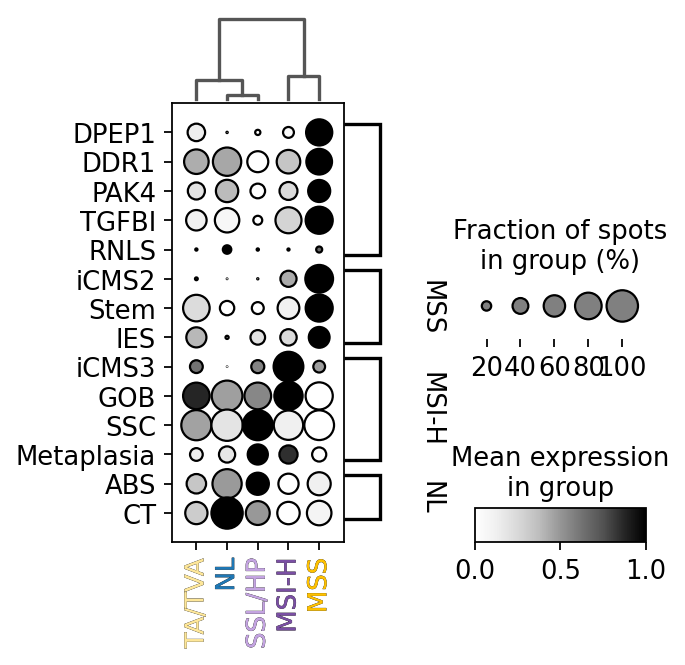

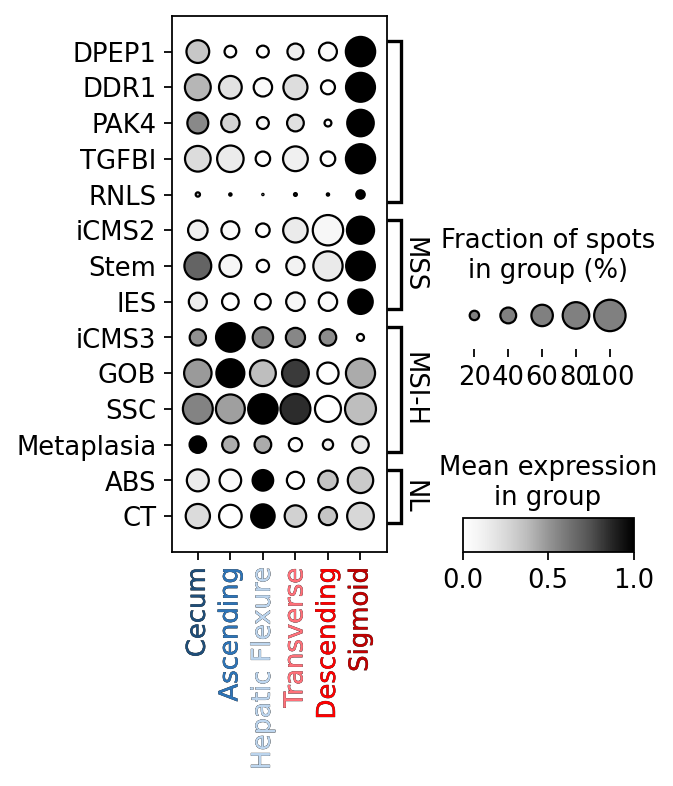

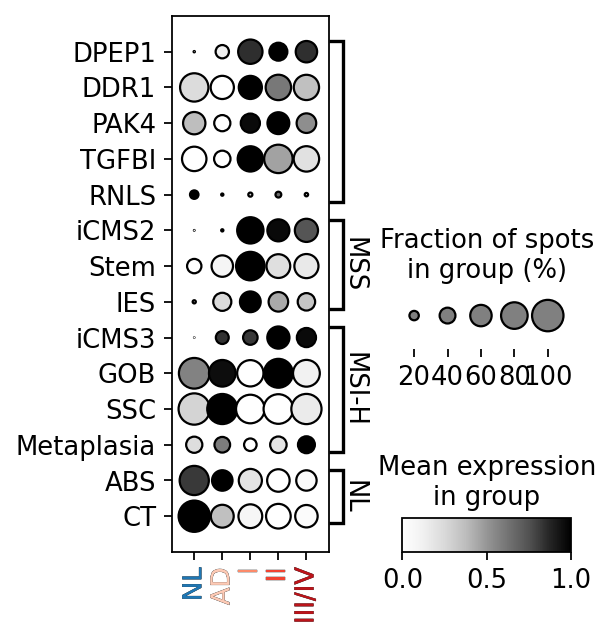

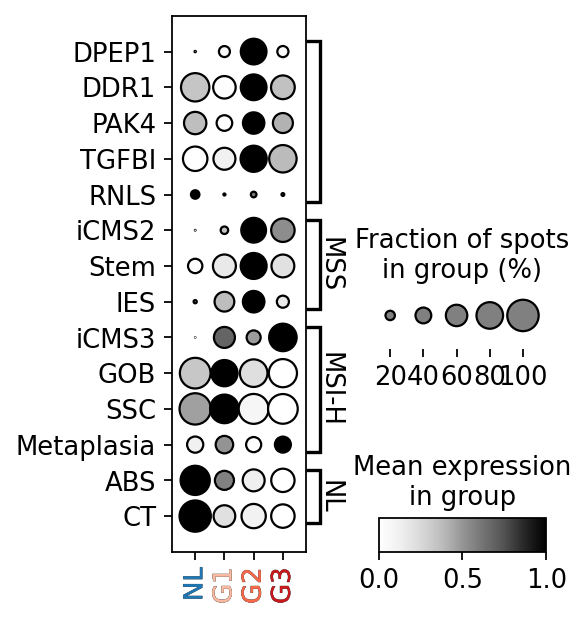

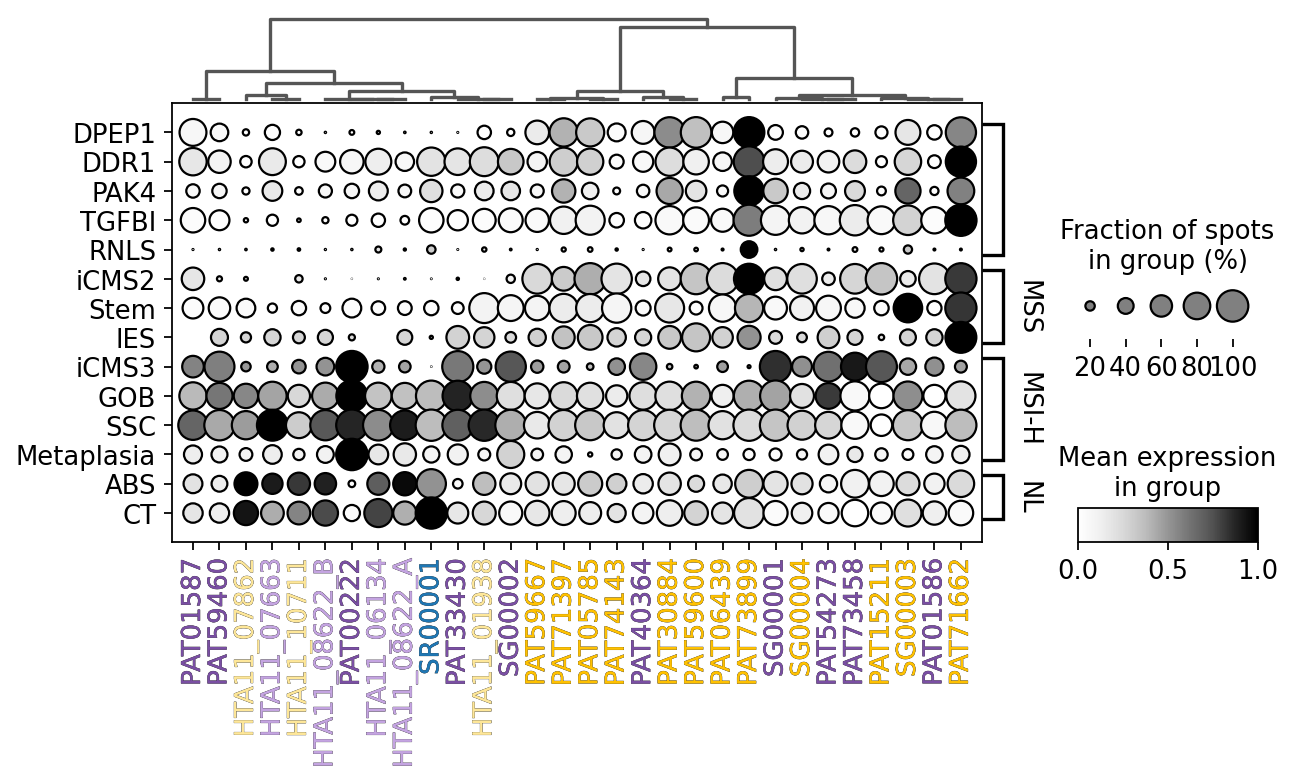

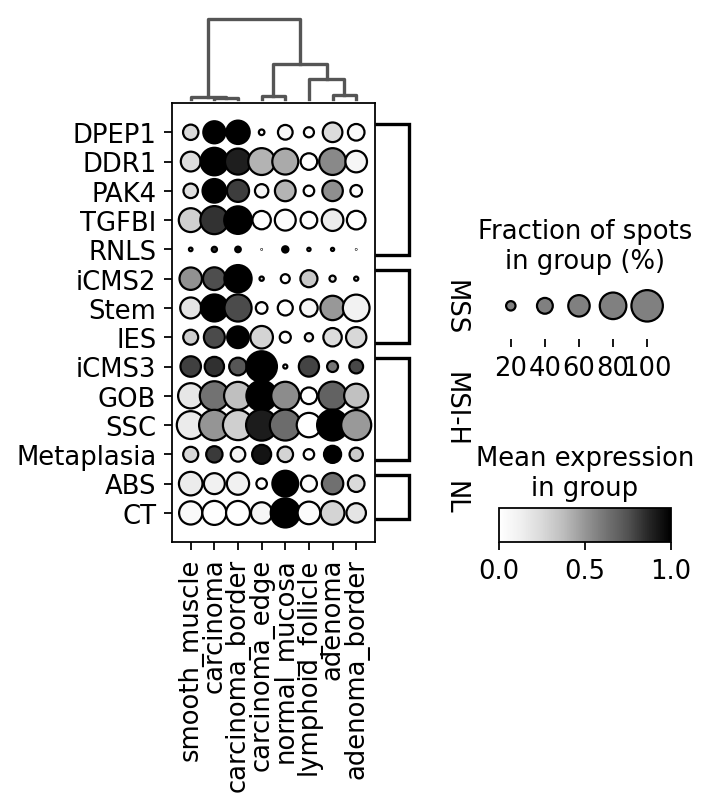

In [31]:
for features_name, features_list, height in zip(
        ["RJC_genes"],
        [custom_dict],
        [custom_dict_height],
    ):
    for group_name, group, width, groupby_order, groupby_colordict, in zip(
        ["tumortype", "tumorloc", "tumorstage", "tumorgrade", "patient", "pathology_annotation"],
        ["Tumor Type", "Tumor Location", "Tumor Stage", "Tumor Grade", "Patient", "pathology_annotation"],
        [tumor_type_width, tumor_loc_width, tumor_stage_width, tumor_grade_width, patient_width, pathology_width],
        [None, ["Cecum","Ascending","Hepatic Flexure","Transverse","Descending","Sigmoid"], ["NL","AD","I","II","III/IV"], ["NL","G1","G2","G3"], None, None],
        [cmap_dict, cmap_dict, cmap_dict, cmap_dict, patient_colordict, None],
    ):
        cody_heatmap(
            a_comb,
            groupby=group,
            features=sum(custom_dict.values(), []),
            cluster_vars=False,
            vars_dict=custom_dict,
            groupby_order=groupby_order,
            groupby_colordict=groupby_colordict,
            cluster_obs=True if groupby_order is None else False,
            figsize=(width, height),
            save="plots_overview/{}_{}_dotplot.png".format(group_name, features_name),
            dpi=400,
            cmap="Greys",
            size_title="Fraction of spots\nin group (%)",
        )